In [1]:
import warnings
warnings.filterwarnings('ignore')

Forest loss region type: <class 'shapely.geometry.polygon.Polygon'>
Extracted coordinates: [[166.5423994  167.76815689]
 [164.54347105 167.77151967]
 [164.53673357 163.7663779 ]
 [166.53566273 163.76301586]
 [166.5423994  167.76815689]]
Mask min: 0, Mask max: 0
Forest loss region type: <class 'shapely.geometry.polygon.Polygon'>
Extracted coordinates: [[159.10315931 191.52585793]
 [155.10296789 191.52833753]
 [155.10172771 189.5276088 ]
 [153.10163266 189.52884868]
 [153.09666929 181.52593339]
 [151.09657524 181.52717441]
 [151.09160729 173.52425776]
 [149.09151424 173.52549993]
 [149.08902863 169.52404125]
 [145.08884421 169.52652639]
 [145.08760124 167.52579746]
 [149.08778533 167.52331166]
 [149.0865417  165.5225819 ]
 [151.08663407 165.52133841]
 [151.08538994 163.52060816]
 [153.08548247 163.51936418]
 [153.08423784 161.51863342]
 [151.08414548 161.51987773]
 [151.0829007  159.51914714]
 [155.08308541 159.5166577 ]
 [155.07934806 153.51446294]
 [157.0794404  153.51321698]
 [157.078

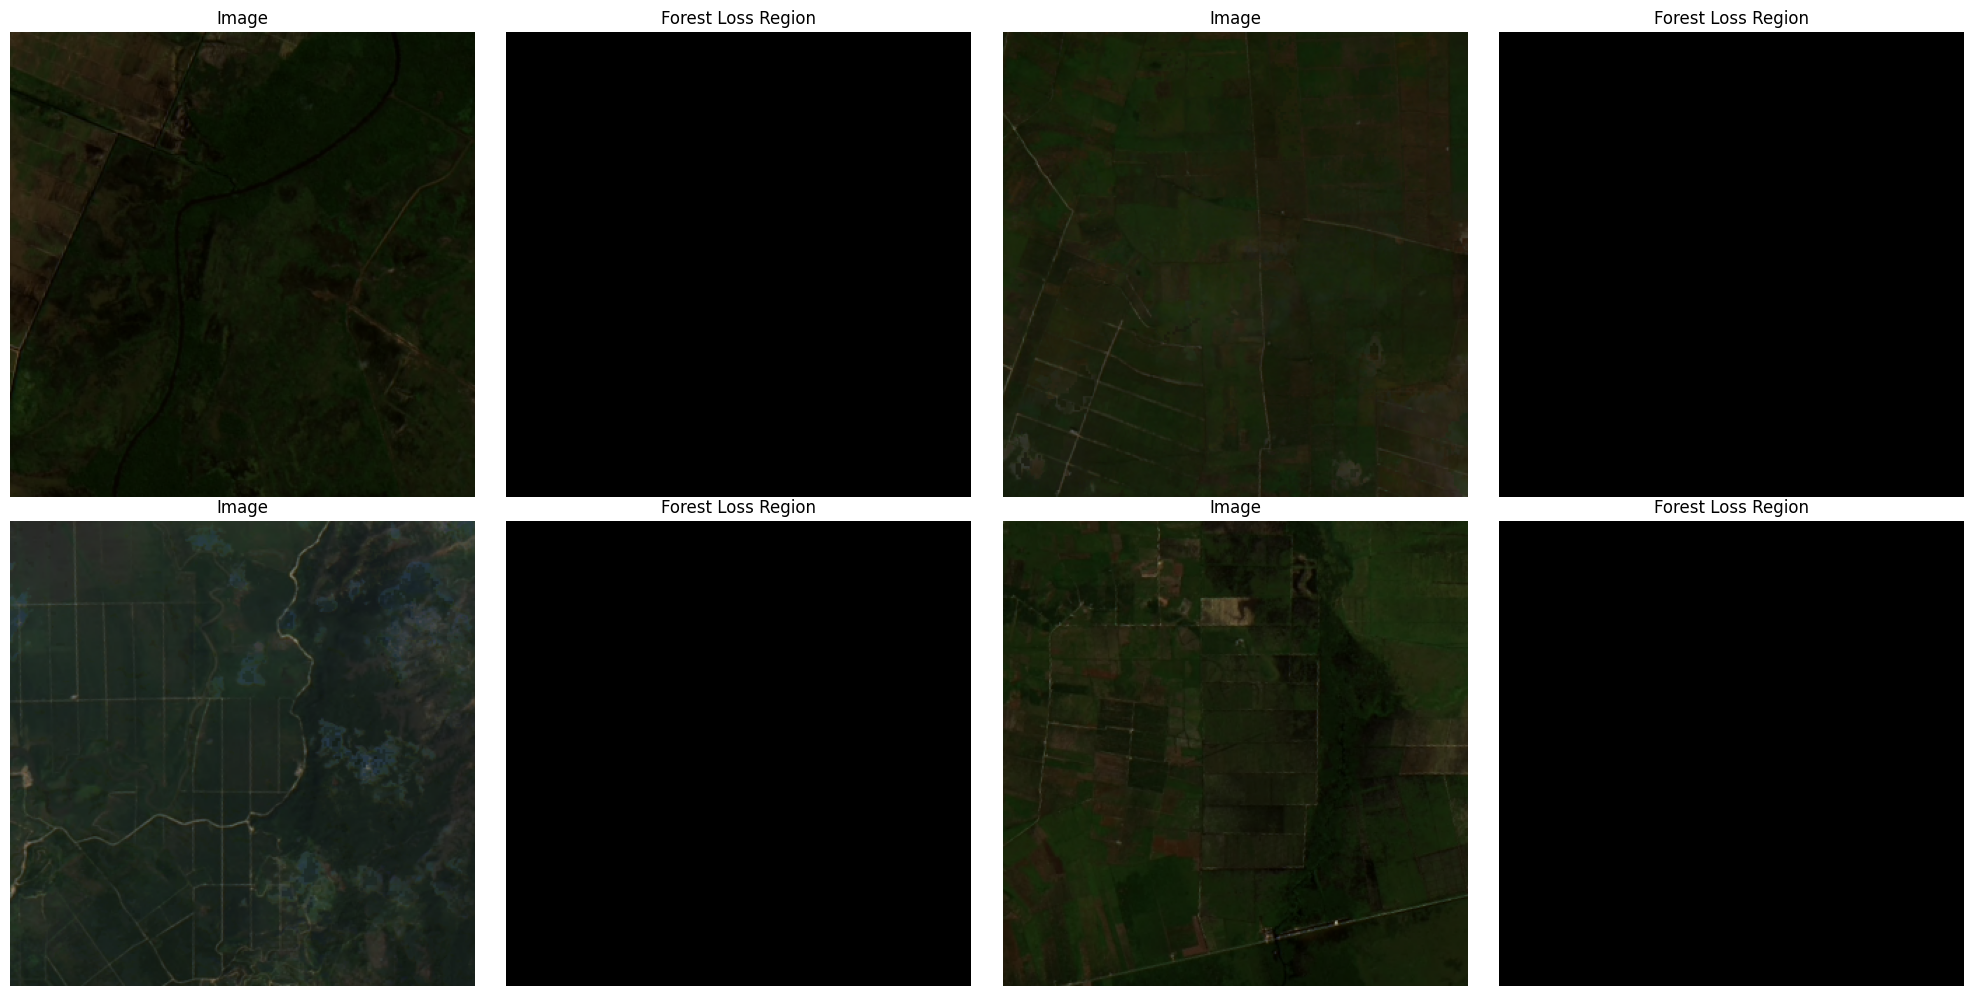

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from PIL import Image
import shapely
import skimage.draw as skdraw
import pickle
import json
import os
from glob import glob

# Define `getEdges`, `createPILMask`, `labelToInt`, and `PILMask.create`

def getEdges(polygon):
    """
    Convert a Shapely Polygon or MultiPolygon to a list of edges suitable for mask creation.
    """
    if polygon.geom_type == 'Polygon':
        coords = np.array(polygon.exterior.coords)
    elif polygon.geom_type == 'MultiPolygon':
        coords = []
        for poly in polygon.geoms:
            coords.extend(np.array(poly.exterior.coords))
        coords = np.array(coords)
    else:
        raise ValueError("Unsupported geometry type")
    
    # Debug: Print information about the extracted coordinates
    print(f"Extracted coordinates: {coords}")
    return coords


def labelToInt(label, codes_dict):
    """
    Convert a label to an integer using the provided dictionary.
    """
    return codes_dict.get(label, 0)  # Return 0 if the label is not found in the dictionary

def createPILMask(poly, label, codes_dict=None):
    mask = np.zeros((332, 332))
    
    if poly.geom_type == 'Polygon':
        edge = getEdges(poly)
        pmask = skdraw.polygon2mask((332, 332), edge)
        mask = np.logical_or(mask, pmask)
    elif poly.geom_type == 'MultiPolygon':
        for polygon in poly.geoms:
            edge = getEdges(polygon)
            pmask = skdraw.polygon2mask((332, 332), edge)
            mask = np.logical_or(mask, pmask)
    
    mask = np.uint8(mask)
    
    if codes_dict:
        mask = mask * labelToInt(label, codes_dict)
    
    mask = np.rot90(mask, 1)
    
    # Debugging: Check if the mask is not just black
    print(f"Mask min: {mask.min()}, Mask max: {mask.max()}")
    
    return Image.fromarray(mask)  # Use PIL to create the image

# Load auxiliary data
def load_auxiliary_data(auxiliary_path):
    gfc = np.load(os.path.join(auxiliary_path, 'gfc.npy'))
    ncep = np.load(os.path.join(auxiliary_path, 'ncep.npy'))
    with open(os.path.join(auxiliary_path, 'osm.json'), 'r') as f:
        osm = json.load(f)
    with open(os.path.join(auxiliary_path, 'peat.json'), 'r') as f:
        peat = json.load(f)
    srtm = np.load(os.path.join(auxiliary_path, 'srtm.npy'))
    return gfc, ncep, osm, peat, srtm

# Find the closest image
def find_closest_image(image_dir, target_year):
    image_files = glob(os.path.join(image_dir, "*.png"))
    closest_image = None
    closest_diff = float('inf')
    
    for img_file in image_files:
        filename = os.path.basename(img_file)
        if 'composite.png' in filename:
            continue
        img_year = int(filename.split('_')[0])
        diff = abs(img_year - target_year)
        if diff < closest_diff:
            closest_diff = diff
            closest_image = img_file
    
    if closest_image is None:
        closest_image = os.path.join(image_dir, 'composite.png')
    
    return closest_image

# Load forest loss region
def load_forest_loss_region(pkl_file):
    with open(pkl_file, 'rb') as f:
        forest_loss_region = pickle.load(f)
    # Debug: Print some information about the forest_loss_region
    print(f"Forest loss region type: {type(forest_loss_region)}")
    if isinstance(forest_loss_region, (list, tuple)):
        print(f"Number of items in forest_loss_region: {len(forest_loss_region)}")
        if len(forest_loss_region) > 0:
            print(f"First item type: {type(forest_loss_region[0])}")
    return forest_loss_region


# Create input
def create_input(csv_row, dataset_dir):
    example_path = os.path.join(dataset_dir, csv_row['example_path'])
    target_year = csv_row['year']
    
    image_path = find_closest_image(os.path.join(example_path, 'images/visible'), target_year)
    image = np.array(Image.open(image_path))
    
    auxiliary_path = os.path.join(example_path, 'auxiliary')
    auxiliary_data = load_auxiliary_data(auxiliary_path)
    
    pkl_file = os.path.join(example_path, 'forest_loss_region.pkl')
    forest_loss_region = load_forest_loss_region(pkl_file)
    
    codes_dict = {'forest_loss': 1, 'no_loss': 0}  # Example dictionary
    segmented_image = createPILMask(forest_loss_region, csv_row['merged_label'], codes_dict)
    
    return image, auxiliary_data, segmented_image

# Visualize random images
def visualize_random_images(df, dataset_dir, num_images=4):
    sampled_rows = df.sample(n=num_images)
    
    fig, axes = plt.subplots(2, num_images, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, (index, row) in enumerate(sampled_rows.iterrows()):
        image, _, segmented_image = create_input(row, dataset_dir)
        
        axes[2*i].imshow(image)
        axes[2*i].set_title('Image')
        axes[2*i].axis('off')
        
        axes[2*i + 1].imshow(segmented_image, cmap='gray')
        axes[2*i + 1].set_title('Forest Loss Region')
        axes[2*i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
dataset_dir = 'ForestNetDataset\deep\downloads\ForestNetDataset'
csv_file = os.path.join(dataset_dir, 'train.csv')
df = pd.read_csv(csv_file)

visualize_random_images(df, dataset_dir)
